# Dynamically Controlled Kernel Estimation (DCKE): Fast and Accurate Estimation of Conditional Expectations
<div style="text-align: right">(C) <a href="https://github.com/niknow">Nikolai Nowaczyk</a>, <a href="https://github.com/Lapsilago">Jörg Kienitz</a> 2020</div>

Fast and accurate estimates of conditional expectations are needed in many financial applications. We review various classical methods such as linear and local regression, Kernel density estimation and Gaussian process regression and show how those can lead to a model free data driven approach to estimating conditional expectations. This notebook serves as an illustration to our paper:

* G.Lee, J. Kienitz, N.Nowaczyk, Q. Geng. *Dynamically Controlled Kernel Estimation*. https://ssrn.com/abstract=3829701


In [34]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as wdg
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor
import GPy
import scipy.stats as ss
from numpy.polynomial.polynomial import polyval, polyder
import matplotlib.ticker as mtick
from mpl_toolkits import mplot3d
from IPython.display import Image

from locreg import LocalRegression
from models.black_scholes import BlackScholes
from dcke.dcke import DCKE

## Financial Motivation
The computation of conditional expectations is required in many financial applications, most notably:
* valuation of derivatives with early exercise features (e.g. American options)
* efficient xVA calculations
* calibration of local stochastic volatility models

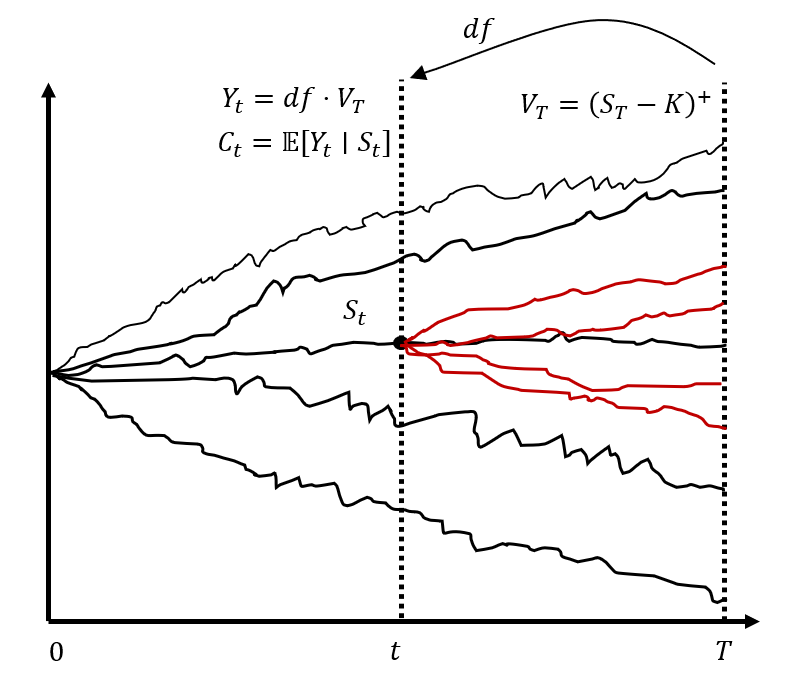

In [51]:
Image(filename='pics/american_option_pricing.png')

## Longstaff/Schwarz Monte Carlo Method (LSM)
In theory, conditional expectations can always be estimated with Nested Monte Carlo simulations, but those are prohibitively expensive. The market standard method to estimate conditional expectations in finance for American Monte Carlo (AMC) is LSM.

* based on linear regression
* can fail to converge properly 
* convergence is dependent on the choice of basis functions
* convergence is particularly difficult in the tails (needed for risk management)
* approximation does not commute with taking derivatives (needed for hedge sensitivities)
* many techniques have been suggested to improve this

## Features of DCKE
We address the shortcomings of LSM by introducing a novel technique, called DCKE, that is
* based on a combination of local regression with control variates, kernel density estimation and Gaussian process regression
* model free and data driven
* produces a minimal-variance delta approximation as a byproduct
* converges quite fast even in the tails

# Problem Setup
Let $(\Omega, \mathcal{F}, \mathbb{P})$ be a probability space and let $Y$ be an $\mathbb{R}$-valued and $X$ be an $\mathbb{R}^d$-valued random variable. We want to calculate he function 
\begin{align*}
    \mu_Y:\mathbb{R}^d \to \mathbb{R}, \; x \mapsto \mathbb{E}[Y \mid X=x],
\end{align*}
i.e. a function can evaluate the conditional expectation of $Y$ given $X=x$ for arbitrary $x$.

## DCKE method (aka Panda algorithm)

**Input**: 
 * a finite set of joint realizations of $X$ and $Y$, i.e. 
 \begin{align*}
     (x_i, y_i) = (X(\omega_i), Y(\omega_i)), &&
     \omega_i \in \Omega, &&
     x_i \in \mathbb{R}^d, &&
     y_i \in \mathbb{R},&&
     i=1, \ldots, N
 \end{align*}
 * an *evaluation set* 
 \begin{align*}
     X^* = (x^*_1, \ldots, x^*_M), &&
     x^*_j \in \mathbb{R}^d.
 \end{align*}
 
**Parameters**:
* a *mesh grid* $x_{i_1}, \ldots, x_{i_k}$ as a subset of $\{x_1, \ldots, x_N\}$
* a degree $p$ for local regression
* a kernel function $K$ for local regression and GPR
* realizations $Z=(Z_1, \ldots, Z_N)$ of a control variate and for each $x_{i_{\nu}}$ a corresponding $\mu_Z(x_{i_{\nu}})$. 

**Output:** Approximations to the conditional expectation function of $Y$ given $X$ on $X^*$, i.e.
\begin{align*}
    y_* = (y^*_1, \ldots, y^*_M), &&
    y^*_j \in \mathbb{R}, &&
    y^*_j \approx \mathbb{E}[Y \mid X = x^*_j].
\end{align*}

**Calculation Steps:**
1. Local Regression: For each point $x=x_{i_{\nu}}$ on the mesh grid, use local regression to compute $\tilde y_{i_{\nu}} \approx \mathbb{E}[Y \mid X=x_{i_{\nu}}]$.
2. Control Variate: For each point $x=x_{i_{\nu}}$ on the mesh grid, use local regression to compute $\tilde z_{i_{\nu}} \approx \mathbb{E}[Z \mid X=x_{i_{\nu}}]$ as well as the approximate optimal $\hat \beta_{\nu}^*$.
3. Perform a Gaussian Process regression of $x_{i_{\nu}}$ vs. $\bar y_{i_{\nu}} := \tilde y_{i_{\nu}} + \beta_{\nu}^*(\tilde z_{i_{\nu}} - \mu_Z(x_{i_{\nu}}))$ using the kernel $K$ and to obtain the outputs $y^*_j$.

## Performance Teaser of DCKE

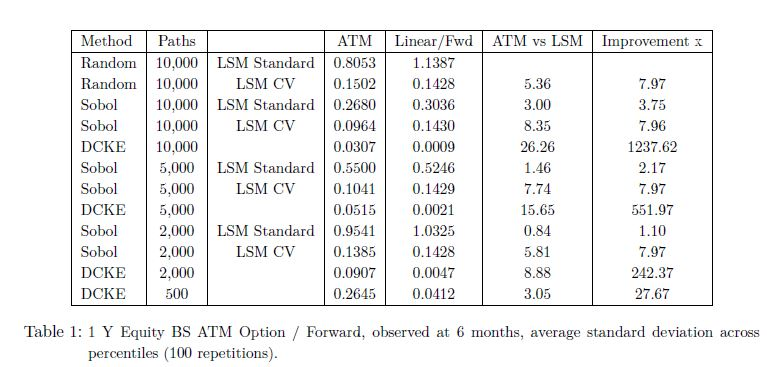

In [4]:
Image(filename='pics/dcke_performance.jpg')

# Reminder of Conditional Expectations

**Definition (conditional probability of events)**:
Let $A \in \mathcal{F}$. For any $B \in \mathcal{F}$ the quanitity
\begin{align}
    \mathbb{P}[B \mid A] := \begin{cases} 
        \frac{\mathbb{P}[B \cap A]}{\mathbb{P}[A]}, & \mathbb{P}[A] > 0, \\ 
        0, & \mathbb{P}[A]=0.  \end{cases}
\end{align}
is the *conditional probability of $B$ given $A$*.

**Lemma (simple Bayes' formula):** For any two $A,B \in \mathcal{F}$ such that $\mathbb{P}(A), \mathbb{P}(B) > 0$,
\begin{align}
    \mathbb{P}(A \mid B) 
    = \frac{\mathbb{P}(A \cap B)}{\mathbb{P}(B)} 
    = \frac{\mathbb{P}(B \cap A)\mathbb{P}(A)}{\mathbb{P}(B)\mathbb{P}(A)} 
    = \frac{\mathbb{P}(B \mid A)}{\mathbb{P}(B)} \mathbb{P}(A). 
\end{align}

**Definition (conditional expectation given a $\sigma$-algebra):** Let $\mathcal{G} \subset \mathcal{F}$ be an arbitrary $\sigma$-subalgebra and $Y \in L^1(\mathcal{F})$. A $\mathcal{G}$-measurable random variable $E$ is a *conditional expectation of $Y$ given $\mathcal{G}$*, if
\begin{align}
    \forall A \in \mathcal{G}: \mathbb{E}[1_A E] = \mathbb{E}[1_A Y].
\end{align}
One can show that $E$ is $\mathbb{P}$-a.s. unique and we set
\begin{align}
    \mathbb{E}[Y \mid  \mathcal{G}] := E.
\end{align}
Furthermore, for any event $B \in \mathcal{F}$, we define
\begin{align}
    \mathbb{P}[B \mid \mathcal{G}] := \mathbb{E}[1_B \mid \mathcal{G}]
\end{align}
and for any random varible $X$ we set 
\begin{align}
    \mathbb{E}[Y \mid X] := \mathbb{E}[Y \mid \sigma(X)]
\end{align}
and finally
\begin{align}
    \mathbb{E}[Y \mid X = x] := \mathbb{E}[Y \mid X](\omega), \quad X(\omega)=x.
\end{align}

**Theorem (orthogonal Projection)**: Let $Y \in L^2(\mathcal{F})$ be a real random variable and $\mathcal{G} \subset \mathcal{F}$ be a $\sigma$-subalgebra. Then for any $\mathcal{G}$-measurable random variable $Z$:
\begin{align*}
    \mathbb{E}[(Y - Z)^2] = \mathbb{E}[(Y - \mathbb{E}[Y \mid \mathcal{G}])^2] + \mathbb{E}[(\mathbb{E}[Y \mid \mathcal{G}] - Z)^2]
\end{align*}

**Corollary**: In particular if $X$ is a real random variable, $\mathcal{G} = \sigma(X)$ and $f:\mathbb{R} \to \mathbb{R}$ is measurable, then
\begin{align*}
    \| Y - f(X) \|_{L^2}^2 = \|Y - \mathbb{E}[Y \mid X]\|_{L^2}^2 + \|\mathbb{E}[Y \mid X] - f(X)\|_{L^2}^2.
\end{align*}

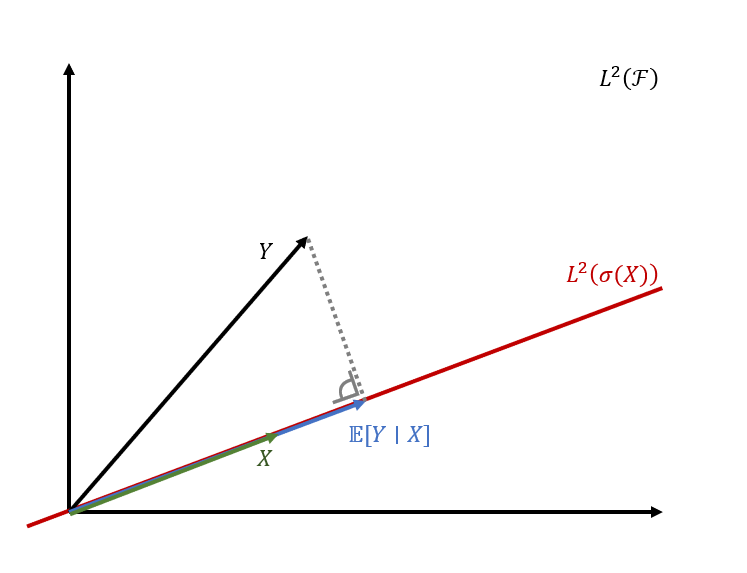

In [52]:
Image(filename='pics/conditional_expectation_orthogonal_projection.png')

**Definition (Markov kernel)** Let $(\Omega, \mathcal{A})$ and $(B, \mathcal{B})$ be measurable spaces. A *Markov kernel* from $(\Omega, \mathcal{A})$ to $(B, \mathcal{B})$ is a function $\kappa: \Omega \times \mathcal{B} \to [0,1]$ such that
*  $\forall \omega \in \Omega: \mathcal{B} \to [0,1], B \mapsto \kappa_{\omega}(B) := \kappa(\omega, B)$ is a probability measure on $(B, \mathcal{B})$.
* $\forall B \in \mathcal{B}: \Omega \to [0,1]$, $\omega \mapsto \kappa_B(\omega) := \kappa(\omega, B)$ is $\mathcal{A}$-$\mathcal{B}([0,1])$-measurable.

**Definition (regular conditional distribution):** Let $X:(\Omega, \mathcal{A}) \to (B, \mathcal{B})$ be a random variable on a probability space $(\Omega, \mathcal{F}, \mathbb{P})$ and $\mathcal{F} \subset \mathcal{A}$ be a $\sigma$-subalgebra. A Markov kernel $\kappa_{X, \mathcal{F}}:\Omega \times \mathcal{B} \to [0,1]$ from $(\Omega, \mathcal{A})$ to $(B, \mathcal{B})$ such that
\begin{align}
    \forall B \in \mathcal{B}: \kappa_{X, \mathcal{F}}(\omega, B) = \mathbb{P}[X \in B \mid \mathcal{F}](\omega)
\end{align}
for $\mathbb{P}$-almost every $\omega \in \Omega$, is called a *regular version of the conditional distribution of $X$ given $\mathcal{F}$*. Let $Y:(\Omega, \mathcal{A}) \to (\Omega', \mathcal{A}')$ be a random variable. Then a Markov kernel $\kappa_{X, Y}:\Omega' \times \mathcal{B} \to [0,1]$ from $(\Omega', \mathcal{A}')$ to $(B, \mathcal{B})$ defined by
\begin{align}
    (\omega', B) \mapsto \kappa_{X,\sigma(Y)}(Y^{-1}(y), B) = \mathbb{P}[X \in B \mid Y=y]
\end{align}
is called *regular version of the conditional distribution of $X$ given $Y$*.

**Theorem (existence of regular conditional distributions):** Let $X:(\Omega, \mathcal{A}) \to (B, \mathcal{B})$ be a random variable on a probability space $(\Omega, \mathcal{F},\mathbb{P})$ and $\mathcal{F} \subset \mathcal{A}$ be a $\sigma$-subalgebra. Then there exists a regular version of the conditional distribution of $X$ given $\mathcal{F}$, if $(B, \mathcal{B})$ is a complete separable metric space with Borel $\sigma$-field $\mathcal{B}$. (In particular if $(B, \mathcal{B})$ is polish, $(\mathbb{R}^d, \mathcal{B}(\mathbb{R}^d))$ etc.).

# Reminder of Linear Regression

In linear regression we are given a labelled data set $(x_i, y_i)$, $i=1, \ldots, N$, $x_i \in \mathbb{R}^d$, $y_i \in \mathbb{R}$, and we assume that they are related via
\begin{align*}
    y_i = f(x_i) + \varepsilon_i,
\end{align*}
where $\varepsilon_i$ is a realization of a centered iid random variable called the *noise* and $f:\mathbb{R}^d \to \mathbb{R}$ is a measurable function. Both, $f$ and $\varepsilon_i$ are not known in practice. However, we will want to make predictions $f(x)$ for $x \in \mathbb{R}^d$.

**Feature map:** The idea of linear regression is to first extract potentially new features out of the input data by means of a feature map $\Phi:\mathbb{R}^d \to \mathbb{R}^k$. The most prominent feature map is the *polynomial features map*
\begin{align}
    \Phi(x) = \begin{pmatrix}
        1 & x & x^2 & \ldots x^{k-1}
    \end{pmatrix}
\end{align}
and the resulting regression is called *polynomial regression*. 

**Linear Hypothesis:** We then assume that the $\Phi(x_i)$ are linearly related to the $y_i$, i.e. we form the *linear hypothesis*
\begin{align*}
    f_{\beta}(x) = \Phi(x)^{\top} \beta,
\end{align*}
for some coefficient vector $\beta \in \mathbb{R}^k$. 

**Cost Functional:** We fit the coefficients to the data by first defining a cost functional, most prominently the squares 
\begin{align}
    J(\beta) := \sum_{i=1}^N{(f_{\beta}(x_i) - y_i)^2} 
\end{align}
and then second by minimizing this cost functional
\begin{align*}
    \beta_* := \operatorname{argmin}_{\beta}{J(\beta)}
\end{align*}
resulting in the *least squares regression coefficient* $\beta_*$.

**Normal Equations:** If we collect all the inputs in the *design matrix* $X \in \mathbb{R}^{N \times k}$, $X_{ij} := \Phi_j(x_i)$, one can show that $\beta_*$ can be computed from the *normal equations*
\begin{align*}
    X^{\top}X \beta^* = X^{\top} y.
\end{align*}

**Predictions:** Finally, new predictions can then be made by 
\begin{align}
    f_*(x) := f_{\beta_*}(x) = \Phi(x)^{\top} \beta_*.
\end{align}

## Example: Parabolic Fit

In [6]:
x = np.linspace(-1,1,100)  # generate the $x_i$
np.random.seed(1)
e = np.random.normal(0, 0.1, 100)  # generate $\varepsilon_i$
y = x**2 + e # generate $y_i$
X = x[:,np.newaxis]  # convert to training set
poly = PolynomialFeatures(degree=2, include_bias=False) # create the features $\Phi(x_i)$
phi = poly.fit_transform(X)
reg = LinearRegression(fit_intercept=True).fit(phi,y)  # compute the fit

In [7]:
plt.figure()
plt.scatter(x, y, label='train', color='tab:blue')
plt.plot(x, x**2, label='truth', color='k')
plt.plot(x, reg.predict(phi), linewidth=3, color='orange', label='predict', alpha=0.5)
plt.legend()
plt.title('Linear Regression')
plt.show()
print("Score: %f" % reg.score(phi, y))

FigureCanvasNbAgg()

Score: 0.920228


## Regression & Conditional Expectation

### Noisy Regression ($x_i$ vs $y_i$)
In this case, we simply regress the $x_i$'s vs. the $y_i$'s. The linear regression equation 
\begin{align}
    y_i = f(x_i)  + \varepsilon_i
\end{align}
still holds even though in practice one is neither given the $f$ nor the $\varepsilon_i$. The key point here is that this yields an estimate of the conditional expectation, because we can always set
\begin{align*}
    f:\mathbb{R}^d \to \mathbb{R}, && x \mapsto \mathbb{E}[Y \mid X=x]
\end{align*}
and
\begin{align*}
    \varepsilon_i := \varepsilon(\omega_i), && \varepsilon := Y - \mathbb{E}[Y \mid X].
\end{align*}
This does satisfy $\mathbb{E}[\varepsilon]=0$ by the properties of conditional expectation.

**Error Decomposition:** One can show that in this case the quadratic error of the regression output $f_*$ decoposes in theory into
\begin{align*}
    \| Y - f_*(X) \|_{L^2}^2 & = \operatorname{Var}[\varepsilon] + \|f(X) - f_*(X)\|_{L^2}^2.
\end{align*}

### Noise-free Regression ($x_i$ vs $f(x_i)$)
In this case, we regress the $x_i$'s vs. the $f(x_i)$'s resulting in $\varepsilon \equiv 0$. 

The squared error in this case is given by 
\begin{align*}
    \| Y - f_*(X) \|_{L^2}^2 & = \|f(X) - f_*(X)\|_{L^2}^2.
\end{align*}

The advantage of the noise-free regression is obviously that it converges faster as the noise term is dropped from the error. The disadvantage is that one needs to know the $f(x_i)$.

### Almost noise-free Regression
This idea combines the two approaches: In general, we might not know the exact values $f(x_i) = \mathbb{E}[Y \mid X=x_i]$, but just for the input values $x_i$, we can use (potentially expensive) numerical techniques to produce nearly exact values $\hat f(x_i) = \hat{\mathbb{E}}[Y \mid X=x_i]$ and then regress $x_i$ vs. $\hat f(x_i)$.

## Example: Normal Distributions & Conditional Expectations
We illustrate the noisy and noise-free case with an example where the true value $f(x)=\mathbb{E}[Y \mid X=x]$ is known analytically. Assume that $(X,Y)$ is bi-variate normal, i.e.
\begin{align*}
    \begin{pmatrix}
        X \\
        Y
    \end{pmatrix}
    \sim \mathcal{N}\Big( 
        \begin{pmatrix} \mu_X \\ \mu_Y \end{pmatrix}, 
        \begin{pmatrix}
            \sigma_X^2 & \rho_{XY} \sigma_X \sigma_Y \\
            \rho_{XY} \sigma_X \sigma_Y & \sigma_Y^2
    \end{pmatrix} \Big).
\end{align*}
Then $X$ and $Y$ are both univariate normal and the conditional expectation can be computed analytically via
\begin{align*}
    \forall x \in \mathbb{R}: f(x) := \mathbb{E}[Y \mid X=x] &= \mu_Y + \rho_{XY} \frac{\sigma_Y}{\sigma_X}(x - \mu_X).
\end{align*}

In [8]:
mu_X = 1
mu_Y = 2
sigma_X = 3
sigma_Y = 4
sigma_XY = 5
rho_XY = 0.4
mu = np.array([mu_X, mu_Y])
Sigma = np.array([[sigma_X**2, rho_XY * sigma_X * sigma_Y],[rho_XY * sigma_X * sigma_Y, sigma_Y**2]])

def cond_exp(x):
    return mu_Y + rho_XY*sigma_Y/sigma_X*(x - mu_X)

In [9]:
fig_condreg, ax_condreg = plt.subplots()

@wdg.interact(N=wdg.IntSlider(min=2, max=1000, value=2))
def plot_regression(N):
    ax_condreg.clear()
    np.random.seed(1)
    W = np.random.multivariate_normal(mu, Sigma, N)
    X = W[:, 0]
    Y = W[:, 1]
    x_grid = np.linspace(mu_X-3*sigma_X, mu_X+3*sigma_X, num=100)
    reg_XY = LinearRegression().fit(np.atleast_2d(X).T,np.atleast_2d(Y).T)
    y_hat_XY = reg_XY.predict(np.atleast_2d(x_grid).T)
    reg_EYX = LinearRegression().fit(np.atleast_2d(X).T,np.atleast_2d(cond_exp(X)).T)
    y_hat_EYX = reg_EYX.predict(np.atleast_2d(x_grid).T)
    ax_condreg.scatter(X,Y, s=10, label='$(x_i, y_i)$')
    ax_condreg.scatter(X,cond_exp(X), s=10, marker='x', label='$(x_i, f(x_i))$')
    ax_condreg.plot(x_grid, y_hat_XY, color='r', label='reg $x_i$ vs $y_i$')
    ax_condreg.plot(x_grid, y_hat_EYX, color='g', label='reg $x_i$ vs $f(x_i)$ (noise-free)')
    ax_condreg.plot(x_grid, cond_exp(x_grid), color='k', linestyle='--', label='$f(x)=\mathbb{E}[Y \mid X=x]$')
    ax_condreg.set_xlim([mu_X-3*sigma_X, mu_X+3*sigma_X])
    ax_condreg.set_ylim([mu_Y-4*sigma_Y, mu_Y+4*sigma_Y])
    ax_condreg.legend()

FigureCanvasNbAgg()

interactive(children=(IntSlider(value=2, description='N', max=1000, min=2), Output()), _dom_classes=('widget-i…

**Conclusions & Remarks:** 
* The noise-free regression captures the true value nearly exactly for any $N \geq 2$ paths.
* The noisy regression converges against the true value too, but much slower.

## Example: Sine Function
Now, let us consider the example $f(x)=\sin(x)$, which does not globally behave at all like a polynomial.

In [10]:
n = 250
x_sin = np.linspace(-20, 20, n)
np.random.seed(1)
e_sin = np.random.normal(0, 0.1, n)
y_sin = np.sin(x_sin) + e_sin
X_sin = x_sin[:,np.newaxis]

In [11]:
lr_preds = {}
lr_scores = {}
d_max = 20
for d in range(1, d_max):
    poly = PolynomialFeatures(degree=d, include_bias=False) 
    phi = poly.fit_transform(X_sin)
    reg = LinearRegression(fit_intercept=False).fit(phi,y_sin)
    lr_preds[d] = reg.predict(phi)
    lr_scores[d] = reg.score(phi, y_sin)

In [12]:
plt.figure()

@wdg.interact()
def plot_sine(d=wdg.IntSlider(min=1, max=d_max-1, value=1)):
    plt.cla()
    plt.scatter(x_sin, y_sin, color='b', label='train')
    plt.plot(x_sin, np.sin(x_sin), color='k', label='truth', linestyle='--')
    plt.plot(x_sin, lr_preds[d], color='orange', linewidth=3, label='predict', alpha=0.5)
    plt.legend()
    plt.title('Linear Regression')
    plt.gca().set_ylim([-1.1, 1.1])
    plt.show()
    print("Score: %f" % lr_scores[d])

FigureCanvasNbAgg()

interactive(children=(IntSlider(value=1, description='d', max=19, min=1), Output()), _dom_classes=('widget-int…

**Conclusion:** We conclude that even with crazy high degrees, the polynomial regression does not capture the function $f(x)=\sin(x)$ very well. That is because $\sin(x)$ is not a polynomial in itself and globally not close to one. One can represent it as a power series, i.e. one can think of it as the polynomial with infinite degree
\begin{align*}
    f(x) = \sin(x) = \sum_{n=0}^{\infty}{\frac{(-1)^n}{(2n +1)!}x^{2n + 1}}.
\end{align*}

# Local Regression

The idea of local regression is to acknowledge that not every function $f$ behaves gobally like a polynomial, but differentiable functions behave locally like polynomials. 

**Taylor's Theroem:** Let $f:U \subset \mathbb{R}^d \to \mathbb{R}$ be a function and let $f$ be differentiable at $x \in U$ of order $p$. Then the *Taylor polynomial of $f$ at $x$ of degree $p$*
\begin{align*}
    T[f; x; p](a) := \sum_{|\alpha| \leq p}{\frac{\partial^{\alpha}f(x)}{\alpha!}(a-x)^{\alpha}}
\end{align*}
has the property that the error satisfies
\begin{align*}
    f - T[f; x; p] \in \mathcal{o}(\|a-x\|^{p}), && a \to x.
\end{align*}

**Cost Functional:** The idea of local regression is to adapt the cost functional to the point $x$ at which one wants to make a prediction by replacing $f(x)$ by its Taylor polynomial. Of course its coefficients $\beta_{\alpha} := \frac{\partial^{\alpha}f(x)}{\alpha!}$ are unknown, but they can be determined by minimizing the cost functional 
\begin{align*}
    J_x(\beta) &:= \sum_{i=1}^{N}{(T[f; x; p](x_i) - y_i)^2 w_i}
    = \sum_{i=1}^{N}{\Big(\beta_0 - y_i + \sum_{1 \leq |\alpha| \leq p}{\beta_\alpha(x_i-x)^{\alpha}}\Big)^2 w_i}.
\end{align*}


**Choice of Weights & Kernel Function:** In order to ensure that for $x_i$ close to $x$ the corresponding summand in the cost functional results in a high penalty, while for $x_i$ far away from $x$, the contribution is small, one needs weights $w_i$.

A popular choice of weights $w_i$ is by means of a *kernel function* such as the *exponential kernel*
\begin{align}
    K:\mathbb{R}^d \to \mathbb{R}, && z \mapsto \exp(-\tfrac{\|z\|^2}{2}).
\end{align}
One can scale kernel functions by a *bandwidth* $h > 0 $ via 
\begin{align*}
    K_h(z) := h^{-d} K\Big(\frac{z}{h}\Big)    
\end{align*}
and for some fixed choice of $h$, one then sets the weights as
\begin{align*}
    w_i := K_h(x-x_i).
\end{align*}

**Choice of Bandwidth:** While in theory it is possible to compute the optimal bandwidth, this is difficult in practice. A popular choice of bandwidth is [Silverman's rule of thumb](https://en.wikipedia.org/wiki/Kernel_density_estimation#A_rule-of-thumb_bandwidth_estimator)
\begin{align*}
    h := \Big(\frac{4}{3 N} \Big)^{\tfrac{1}{5}} \hat \sigma_Y,
\end{align*}
where $\hat \sigma_Y$ is the empiricial standard deviation in the $y_i$. There are significantly more elaborate techniques, like variable bandwidth strategies or hyperparameter optimization.

**Prediction:** Once the cost function is optimized, the prediction is performed by
\begin{align*}
    f(x) \approx T[f;x;p](x) = \beta_0.
\end{align*}

**Nadaraya-Watson and Locally Linear Regression:** The case $p=0$ is called *Nadaraya-Watson Regression* and in this case the functional can be minimized analytically via
\begin{align}
    \sum_{i=1}^{N}{W_i(x) y_i}, && W_i(x) := \frac{K_h(x - x_i)}{\sum_{j=1}^{N}{K_h(x-x_j)}}.
\end{align}
Analogously, the case $p=1$ is called *locally linear regression*, which for $d=1$ also has an analytic expression. One can formulate normal equations for any dimension and solve them by either iteratively minimizing the cost functional or solving the normal equation via QR-decomposition for example.

**Error Estimate:** The error [is known](http://sfb649.wiwi.hu-berlin.de/fedc_homepage/xplore/tutorials/xlghtmlnode34.html) to have an asymptotically normal distribution and the width depends on the conditional variance $\sigma_Y(x)^2 := \operatorname{Var}[X \mid X=x]$. More precisely, if there exists a constant $c \in \mathbb{R}$ such that the bandwidth satisfies $h=c N^{-\tfrac{1}{5}}$, then
\begin{align*}
    N^{\tfrac{2}{5}}(\hat \mu_Y(x) - \mu_Y(x)) \to \mathcal{N}\Big( b(x)\frac{c^2}{2}\mu_2(K), \frac{1}{c} \frac{\sigma_Y(x)^2}{f_X(x)}\|K\|_{L^2}^2 \Big),
\end{align*}

where $b(x)$ is an expression for the bias and $f_X$ is the density of $X$. 


## Example: Sine Function

In [13]:
locregnw = LocalRegression(degree=0).fit(X_sin, y_sin)
locregll = LocalRegression(degree=1).fit(X_sin, y_sin)
locreg_preds = {0: locregnw.predict(X_sin),
                1: locregll.predict(X_sin)}
locreg_scores = {0: locregnw.score(X_sin, y_sin),
                 1: locregll.score(X_sin, y_sin)}

In [14]:
plt.figure()
@wdg.interact()
def plot_sine(d_lin=wdg.IntSlider(min=1, max=d_max, value=2, description='Degree Linear Regression'),
              d_loc=wdg.IntSlider(min=0, max=1, value=0, description='Degree Local Regression')):
    plt.cla()
    plt.scatter(x_sin, y_sin, color='b', label='train')
    plt.plot(x_sin, np.sin(x_sin), color='k', label='truth', linestyle='--')
    plt.plot(x_sin, lr_preds[d_lin], color='orange', linewidth=3, label='predict linear', alpha=0.5)
    plt.plot(x_sin, locreg_preds[d_loc], color='g', linewidth=3, label='predict local', alpha=0.5)
    plt.legend()
    plt.title('Linear vs. Local Regression')
    plt.show()
    print("Score Linear Regression: %f" % lr_scores[d_lin])
    print("Score Local Regression: %f" % locreg_scores[d_loc])

FigureCanvasNbAgg()

interactive(children=(IntSlider(value=2, description='Degree Linear Regression', max=20, min=1), IntSlider(val…

## Example: Multivariate Sines
We now illustrate that local regression also works in higher dimensions. In this example, we consider the function $f(x_1, x_2) = \sin(x_1) \sin(x_2)$.

In [15]:
n=20
x1 = np.linspace(-5,5,n)
x2 = np.linspace(-5,5,n)
e = np.random.normal(0, 0.01, (n, n))
y = np.array([[np.sin(xx1)*np.sin(xx2) for xx1 in x1] for xx2 in x2])
y = y + e
x1, x2 = np.meshgrid(x1, x2)
X = np.array(list(zip(x1.flatten(), x2.flatten())))

In [16]:
locreg3d = LocalRegression(degree=0).fit(X, y.flatten())
y_pred = locreg3d.predict(X, method='qr')

In [17]:
plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x1, x2, y, color='b', label='train')
surf = ax.plot_surface(x1, x2, y, color='k', label='truth', alpha=0.3)
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d
surf = ax.plot_surface(x1, x2, y_pred.reshape(n, n), color='g', label='predict', alpha=0.5)
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.legend()
plt.show()

FigureCanvasNbAgg()

In [18]:
locreg3d.score(X, y.flatten())

0.9999769805807223

## Example: Bermudan Call Option in Black-Scholes-Merton Model

In [19]:
# Black-Scholes model
r = 0.01
sigma = 0.3
bs = BlackScholes(sigma=sigma, r=r)

# Black-Scholes paths
S0 = 100.0
time_grid = np.array([0.0, 0.25, 1.])
N = 10000
S = bs.paths(s0=S0, time_grid=time_grid, num_sims=N)

# Black-Scholes option prices
T = time_grid[2]
t = time_grid[1]
df = np.exp(-r*(T-t))
K = 95.
num_quantiles = 100
quantile_levels = np.linspace(0.1, 99.0, num=num_quantiles)
quantile_grid = np.percentile(S[1], quantile_levels, interpolation='nearest')

In [20]:
y_true_bs = np.array([bs.option_price(s, T-t, K) for s in quantile_grid])
bs_delta = np.array([bs.delta(s, T-t, K) for s in quantile_grid])

In [21]:
X = np.atleast_2d(S[1]).T
y = df * np.maximum(S[2]-K,0)
x_eval = np.atleast_2d(quantile_grid).T
locreg = LocalRegression(degree=0)
locreg.fit(X, y)
y_pred_nw = locreg.predict(x_eval)

In [22]:
# LSM
deg = 3
poly = PolynomialFeatures(degree=deg, include_bias=False)
X_LSM = poly.fit_transform(X)
reg = LinearRegression(fit_intercept=True)
reg.fit(X_LSM, np.atleast_2d(y).T)
y_pred_lsm = reg.predict(poly.fit_transform(np.atleast_2d(quantile_grid).T)).squeeze()
delta_lsm = polyval(quantile_grid, polyder(np.concatenate((reg.intercept_ , reg.coef_[0]))),)

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle('Call Option Estimated Conditional Value: NW Regression')
ax[0].plot(x_eval, y_true_bs, color='k', linestyle='--', label='truth')
ax[0].plot(x_eval, y_pred_lsm, label='LSM deg=3')
ax[0].scatter(x_eval, y_pred_nw, label='NW', color='orange', marker='x', s=15)
ax[0].set_xlabel('$S_t$')
ax[0].set_ylabel('$\hat V_t$')
ax[0].set_title('values')
ax[0].legend()
ax[1].plot(x_eval, np.zeros_like(x_eval), color='k', linestyle='--', label='truth')
ax[1].plot(x_eval, y_pred_lsm - y_true_bs, label='LSM')
ax[1].scatter(x_eval, y_pred_nw - y_true_bs, label='NW', color='orange', marker='x', s=15)
ax[1].set_xlabel('$S_t$')
ax[1].set_ylabel('$\hat V_t$')
ax[1].set_title('errors')
ax[1].legend()
plt.show()        

FigureCanvasNbAgg()

**Conclusion:** The Nadaraya-Watson regression is unstable in this situation as the distribution of the points is not uniform and there is too much variance in the data.

# Variance Reduction & Control Variates

## Reminder of Monte Carlo Error

Let $Y$ be a real random variable assumed to be in $L^2$. We want to numerically compute the expectation
\begin{align*}
    \mathbb{E}[Y] =: \mu_Y
\end{align*}

The basic idea of Monte Carlo Simulation is to draw realizations $y_1, \ldots, y_N$ from the distribution of $Y$ and compute the average
\begin{align*}
    \hat \mu_Y := \frac{1}{N}\sum_{i=1}^{N}{y_i}.
\end{align*}

How big is the error $\hat \mu_Y - \mu$? This can be concluded from the following.

**[Theorem (Central Limit Theorem)](https://en.wikipedia.org/wiki/Central_limit_theorem):** Let $Y_1, \ldots, Y_N$ be iid random variables with expectation $\mathbb{E}[Y_i]=\mu$ and variance $\operatorname{Var}[Y_i] = \sigma^2$, $i=1, \ldots, N$. Then the mean $\hat \mu_Y := \frac{1}{N}\sum_{i=1}^N{Y_i}$ satisfies the convergence
\begin{align*}
    \sqrt{N} \frac{\hat \mu_Y - \mu_Y}{\sigma} \to \mathcal{N}(0,1)
\end{align*}
in distribution.

This means that for large $N$, the error $\hat \mu_Y - \mu_Y$ is approximately distributed as $\mathcal{N}(0, \frac{\sigma^2}{N})$. 

## Variance Reduction
If we can replace $Y$ by any other random variable $Y^*$ such that $\mathbb{E}[Y^*] = \mathbb{E}[Y]$, but $\operatorname{Var}[Y^*] < \operatorname{Var}[Y]$, then the estimator $\mu^* := \frac{1}{N}\sum_{i=1}^{N}{Y^*_i}$ converges to the same mean, but at faster speed. This is called *variance reduction*.

## Control Variates

A standard technique to reduce variance are [control variates](https://en.wikipedia.org/wiki/Control_variates): Let $Y$ be a random variable as above and assume that $Z$ is any other $L^2$ random variable with $\mathbb{E}[Z]=:\mu_Z$ and $\beta \in \mathbb{R}$. Then
\begin{align*}
    Y^* := Y + \beta (Z - \mu_Z),
\end{align*}
is a random variable such that 
\begin{align*}
    \mathbb{E}[Y^*] = \mathbb{E}[Y] + \beta (\mathbb{E}[Z] - \mu_Z) = \mu_Y.
\end{align*}

The variance of $Y^*$  is
\begin{align*}
    \operatorname{Var}[Y^*] = \operatorname{Var}[Y] + \beta^2 \operatorname{Var}[Z] + 2 \beta \operatorname{Cov}[Y, Z],
\end{align*}

which is minimized for
\begin{align*}
    \beta^* := - \frac{\operatorname{Cov}[Y, Z]}{\operatorname{Var}[Z]}    
\end{align*}

resulting in a variance of

\begin{align*}
    \operatorname{Var}[Y^*] = (1 - \rho_{Y, Z}^2)\operatorname{Var}[Y].
\end{align*}

**Problem:** Find good candidates for $Z$!

## Example: Control Variates in Action

In [24]:
rho=0.95
N=100
mean = (0, 0)
cov = ((1, rho),(rho, 1))
beta = -rho
np.random.seed(2)
Y, Z = np.random.multivariate_normal(mean, cov, N).T

In [25]:
fig, ax = plt.subplots()
fig.suptitle('Monte Carlo Convergence with and without Control Variate')
ax.plot(range(1, N+1), np.cumsum(Y)/range(1, N+1), label='without CV')
ax.plot(range(1, N+1), np.cumsum(Y+beta*Z)/range(1, N+1), label='with CV')
ax.hlines(0, 1, N+1, label='true value')
ax.set_xlabel('# samples')
ax.set_ylabel('estimate')
ax.legend()
plt.show()

FigureCanvasNbAgg()

## Example: Continuation Values of Bermudan Options in the Black-Scholes Model

In order to apply control variates to the Bermudan options example, we need a conditional version of it.

### Conditional Control Variates
Control variates work for conditional expectations in the same fashion: For any other random variable $Z$ and any $x$, we replace $Y$ by
\begin{align*}
    Y^*_x := Y + \beta_x (Z - \mu_Z(x))
\end{align*}
and 
\begin{align*}
    \beta_x^* = - \frac{\operatorname{Cov}[Y, Z \mid X=x]}{\operatorname{Var}[Z \mid X=x]} \in \mathbb{R}
\end{align*}
minimizes the conditional variance $\operatorname{Var}[Y^*_x \mid X=x]$. 

### Application to option pricing
We apply this to the discounted value  $Y := e^{-r(T-t)} V_T$ of a Bermudan option $V_t$ on a stock $S_t$ on a time grid $0<t<T$. We choose $Z:=e^{-r(T-t)}S_T$ as the control variate. By risk-neutral pricing in a Black-Scholes setting with constant risk-free rate $r$, this is given by
\begin{align*}
    V_t = \mathbb{E}[e^{-r(T-t)}V_T \mid S_t]
\end{align*}
Thus, we set $Y := e^{-r(T-t)} V_T$ and $X := S_t$.

We estimate the values of 
\begin{align*}
    \beta_x^* & = - \frac{\mathbb{E}[(Y-\mathbb{E}[Y \mid X=x])(Z-\mathbb{E}[Z \mid X=x]) \mid X=x]}{\mathbb{E}[(Z-\mathbb{E}[Z \mid X=x])^2 \mid X=x]} \\
    & \approx - \frac{\hat{\mathbb{E}}[(Y-\hat{\mathbb{E}}[Y \mid X=x])(Z-\hat{\mathbb{E}}[Z \mid X=x]) \mid X=x]}{\hat{\mathbb{E}}[(Z-\hat{\mathbb{E}}[Z \mid X=x])^2 \mid X=x]} 
    =: \hat{\beta}_x^*
\end{align*}
where $\hat{\mathbb{E}}[\_ \mid X=x]$ denotes the conditional expectation approximated via Nadaraya-Watson estimation. As $S_t$ is a martingale and 
\begin{align*}
    \mu_Z(x) = \mathbb{E}[Z \mid X=x] = \mathbb{E}[e^{-r(T-t)}S_T \mid S_t=x] = x
\end{align*}
we obtain for any $x$
\begin{align*}
    Y^*_x = e^{-r(T-t)}V_T + \hat \beta_x^*(e^{-r(T-t)}S_T - x)
\end{align*}

### Result
As plotted [here](#bermudan_result) this results in a much better estimate.

# Gaussian Process Regression (GPR)

## Probabilistic View of Linear Regression
The idea (or rather: one approach to) Gaussian Process Regression (GPR) is to consider again the linear regression model
\begin{align}
    y_i = \Phi(x_i)^\top \beta + \varepsilon_i
\end{align}
and take a completely probabilistic view on it. We assume that $\varepsilon_i \sim \mathcal{N}(0, \sigma_n)$ and that $\beta$ as well as $x_i$ (hence $y_i$) are all random variables. For the unknown $\beta$ we assume a *prior distribution*
\begin{align}
    \beta \sim \mathcal{N}(0, \Sigma_p).
\end{align}
In terms of densities, the linear regression model can then be restated via
\begin{align}
    p(y \mid X, \beta) \sim \mathcal{N}(\Phi(X)^\top \beta, \sigma^2_n I)
\end{align}
and from Bayes' theorem we can conversely conclude (via a laborious calculation) that
\begin{align}
    p(\beta \mid y, X) &= \frac{p(y \mid X, \beta)p(\beta)}{p(y \mid X)} 
    \propto \exp\left(-\frac{1}{2}(\beta-\bar{\beta})^\top A (\beta-\bar{\beta})\right),
\end{align}
where
\begin{align}
\bar{\beta} := \frac{(\frac{\Phi(X)^\top \Phi(X)}{\sigma_n^2} +\Sigma_p^{-1})^{-1}\Phi(X) y}{\sigma_n^2}, &&
A := \frac{\Phi(X)^\top \Phi(X)}{\sigma_n^2} + \Sigma_p^{-1}.
\end{align}
This yields to the *posterior distribution*
\begin{align}
    p(\beta \mid X, y) \sim \mathcal{N}\left(\bar{\beta},A^{-1}\right).
\end{align}

For a new value $y_* = f(x_*)$, we obtain the *predictive distribution*
\begin{align}
 p(y_* \mid x_*, X, y) = \int p(y_*| x_*, \beta) p(\beta \mid X, y)d\beta
\sim \mathcal{N}\left(\frac{\Phi(x_*)^\top A^{-1}\Phi(X)y}{\sigma_n^2},\Phi(x_*)^\top A^{-1}\Phi(x_*)\right).
\end{align}


*Kernel Trick:* 
* Notice that in the above expression, we only need to know expressions of the form 
\begin{align}
\Phi(x)^\top \Sigma_p \Phi(x), && \Phi(x_*)^\top \Sigma_p \Phi(x), && \Phi(x_*)^\top \Sigma_p \Phi(x_*)
\end{align}
* Lifting from input space $x$ to feature space $\Phi(x)$ is called the *kernel trick* as those expressions can be rewritten by means of a kernel function $k$, like $k(\phi, \phi_*)$, $\phi:=\Phi(x)$.
* This keeps all the information of the covariances of the model and allows the choice of kernels other than the bilinear kernel $k(\phi,\psi) = \phi^\top \Sigma \psi$.

## Examples
source: [scikit-learn](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py)
### Noise-free case

In [26]:
def f(x):
    return x * np.sin(x)
X_gpr = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T
y_gpr = f(X_gpr).ravel()
x_gpr = np.atleast_2d(np.linspace(0, 10, 1000)).T
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(X_gpr, y_gpr)
y_pred_gpr, sigma = gp.predict(x_gpr, return_std=True)

In [27]:
plt.figure()
plt.plot(x_gpr, f(x_gpr), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X_gpr, y_gpr, 'r.', markersize=5, marker='o', label='Observations')
plt.plot(x_gpr, y_pred_gpr, 'b-', label='Prediction')
plt.fill(np.concatenate([x_gpr, x_gpr[::-1]]),
         np.concatenate([y_pred_gpr - 1.9600 * sigma,
                        (y_pred_gpr + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

FigureCanvasNbAgg()

### Noisy case

In [28]:
X_gpr = np.linspace(0.1, 9.9, 20)
X_gpr = np.atleast_2d(X_gpr).T
y_gpr = f(X_gpr).ravel()
dy_gpr = 0.5 + 1.0 * np.random.random(y_gpr.shape)
noise = np.random.normal(0, dy_gpr)
y_gpr += noise
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy_gpr ** 2,
                              n_restarts_optimizer=10)
gp.fit(X_gpr, y_gpr)
y_pred_gpr, sigma = gp.predict(x_gpr, return_std=True)

In [29]:
plt.figure()
plt.plot(x_gpr, f(x_gpr), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.errorbar(X_gpr.ravel(), y_gpr, dy_gpr, fmt='r.', markersize=10, label='Observations')
plt.plot(x_gpr, y_pred_gpr, 'b-', label='Prediction')
plt.fill(np.concatenate([x_gpr, x_gpr[::-1]]),
         np.concatenate([y_pred_gpr - 1.9600 * sigma,
                        (y_pred_gpr + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

FigureCanvasNbAgg()

## Function Space View and Kernels

More generally, one can define a *Gaussian Process* as a map $f:X \to L^2$  that assigns each element $x$ in the set $X$ a random variable $f(x)$ such that any finite number of these are multivariate Gaussian. 

As any Gaussian process $f$ is uniquely determined by its *mean* and *covariance function*
\begin{align}
    m(x) & = \mathbb{E}[f(x)], \\
    k(x,y)& = \mathbb{E}[(f(x)-m(x))(f(y)-m(y))],
\end{align}
we write $f(x) \sim \mathcal{GP}(m,k)$.

**Example:** The Bayes view of linear regression is given as the Gaussian process $f:\mathbb{R}^d \to L^2$, $x \mapsto \Phi(x)^\top \beta$ for $\beta \sim \mathcal{N}(0, \Sigma_p)$, where $m \equiv 0$ and $k(x,y) = x^\top \Sigma_p y$. The function $k$ is also called a *kernel*. A popular choice of kernel is the *exponential kernel*
\begin{align}
    k(x,y) = \sigma \exp\left(-\frac{\|y-x\|^2}{2 l^2}\right)
\end{align}
for parameters $\sigma, l$. 

**Kernel Reformulation:** This motivates to reformulate this purely in terms of the *kernel functions*. Evaluating any kernel function $k$ training set $X$ and a set $X_*$ on which we want to predict results in matrices $K:=k(X,X)$, $K_* := k(X,X_*)$, $K_{**} := k(X_*, X_*)$. The result $f := f(X)$ and $f_* := f(X_*)$ then satisfies
\begin{align}
\begin{pmatrix}
f\\
f_*
\end{pmatrix}
\sim
\mathcal{N}\left(0, \begin{pmatrix}
K & K_*^\top\\
K_* & K_{**}
\end{pmatrix} \right)
\end{align}
and one can infer
\begin{align}
    f_* \mid f \sim \mathcal{N}(K_*K^{-1}f,K_{**}-K_*K^{-1}K_*^\top).
\end{align}

From this, one can reformulate the predictive distribution as
\begin{align}
    f_* \mid X, y, X_* & \sim \mathcal{N}(\bar{f}_*,\operatorname{cov}(f_*))\\
    \bar{f}_* &:= \mathbb{E}[f_* \mid X,y,X_*] = K_*(K+\sigma_n^2I)^{-1}y\\
    \operatorname{cov}(f_*) &:= K_{**} - K_*(K+\sigma_n^2I)^{-1} K_*^\top.
\end{align}

**Hyperparameters & Optimization:** If one uses kernel with parameters one can optimize the choice of these parameters by optimizing the *logarithmic marginal likelihood*
\begin{align}
    \log(p(y \mid X)) = -\frac{1}{2}y^\top (K+\sigma_n^2I)^{-1}y-\frac{1}{2}\log(|K+\sigma_n^2I|)-\frac{n}{2}\log(2\pi).
\end{align}

# Dynamically Controlled Kernel Estimation (DCKE)
Finally, combining local regressions stablized with control variates with Gaussian process regression yields the DCKE algorithm and we obtain the following result.

In [30]:
dcke = DCKE(locreg=LocalRegression(degree=0),
            gpr_kernel=GPy.kern.RBF(input_dim=1))

df = np.exp(-r*(T-t))

dcke.fit(X=X,
         y=y,
         x_mesh=np.atleast_2d(quantile_grid).T,
         Z=df*S[2],         
         mz=quantile_grid)
y_pred_dcke = dcke.predict(np.atleast_2d(quantile_grid).T)

## Example: Bermudan Option Result
<a id='bermudan_result'></a>

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle('Call Option Estimated Conditional Value: NW Regression')
ax[0].plot(x_eval, y_true_bs, color='k', linestyle='--', label='truth')
ax[0].plot(x_eval, y_pred_lsm, label='LSM deg=3')
ax[0].scatter(x_eval, y_pred_nw, label='NW (without CV)', color='orange', marker='x', s=15)
ax[0].scatter(x_eval, dcke.y_mesh_, label='NW (with CV)', color='green', marker='x', s=15)
ax[0].plot(x_eval, y_pred_dcke, label='DCKE', color='red')
ax[0].set_xlabel('$S_t$')
ax[0].set_ylabel('$\hat V_t$')
ax[0].set_title('values')
ax[0].legend()
ax[1].plot(x_eval, np.zeros_like(x_eval), color='k', linestyle='--', label='truth')
ax[1].plot(x_eval, y_pred_lsm - y_true_bs, label='LSM')
ax[1].scatter(x_eval, y_pred_nw - y_true_bs, label='NW (without CV)', color='orange', marker='x', s=15)
ax[1].scatter(x_eval, dcke.y_mesh_ - y_true_bs, label='NW (with CV)', color='green', marker='x', s=15)
ax[1].plot(x_eval, y_pred_dcke - y_true_bs, label='DCKE', color='red')
ax[1].set_xlabel('$S_t$')
ax[1].set_ylabel('$\hat V_t$')
ax[1].set_title('erros')
ax[1].legend()
plt.show() 

FigureCanvasNbAgg()

## Call Option in Rough Bergomi Model

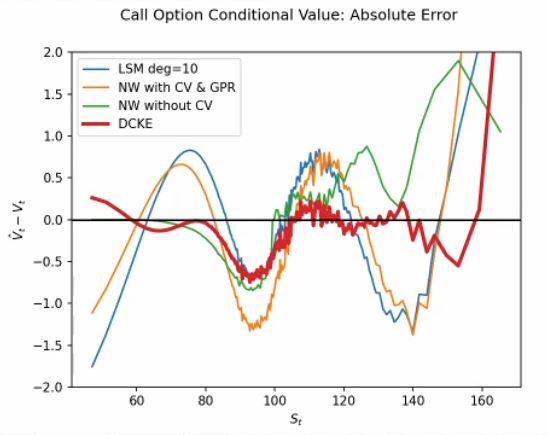

In [32]:
Image(filename='pics/dcke_rbergomi.jpg')

## Basket Option in Heston Model

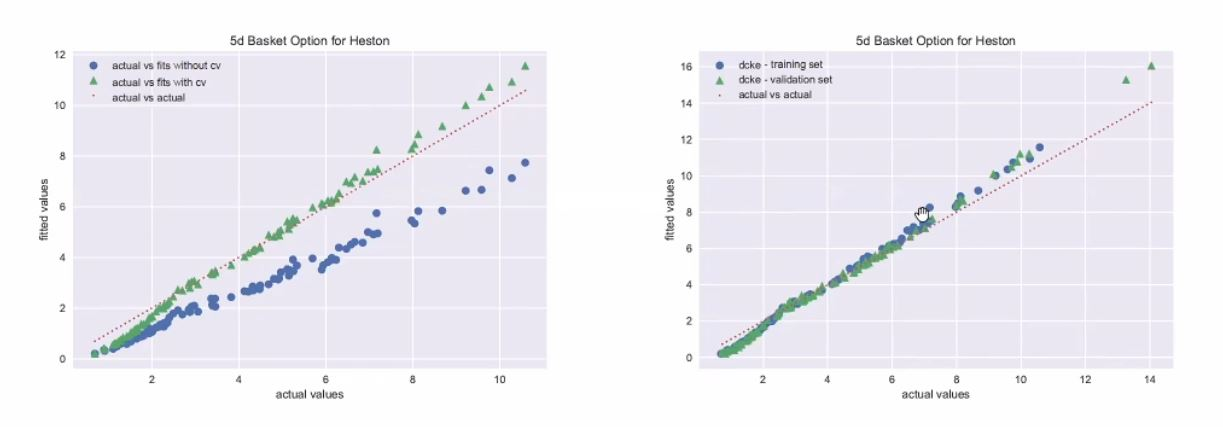

In [33]:
Image(filename='pics/dcke_basket_heston.jpg')